# Shap and Lime for XIR (Explaining No-Interaction Models)

### Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import tomllib
from pathlib import Path
import numpy as np
from IPython.display import display, HTML
from src.modules.loader.data_loader import DataLoader
from src.modules.loader.statspearls_data_loader import StatPearlsDataLoader
from src.modules.loader.medmcqa_data_loader import MedMCQADataLoader
from src.modules.loader.medmcqa_data_loader import format_medmcqa_question
from src.modules.llm.llm_client import LLMClient
from src.modules.rag.rag_engine import RAGEngine
from src.modules.rag.multihop_rag_engine import MultiHopRAGEngine
from src.modules.explainers.shap_explainer import ShapExplainer
from src.modules.explainers.lime_explainer import LimeExplainer

In [2]:
# helper function for displaying results

def display_results(explainer, explanations):

    for question_explanation in explanations:
        print(f"\n \33[1m===== Results for Question: =====\33[0m \n {question_explanation["question"]}\n")

        print(f"\033[1mQuery for Hop_1\033[0m:\n{question_explanation["explanation"]["hop_1"][0]["query"]}\n")
        hop_1 = question_explanation["explanation"]["hop_1"]
        for i, context_doc in enumerate(hop_1):
            display(HTML( f"<h3>Document {i + 1}</h3>"))
            explainer.plot_text_heatmap(context_doc)
            explainer.plot_bar(context_doc)

        print(f"\n \33[1m------------------------------------\33[0m")
        print(f"\n \033[1mQuery for Hop_2\033[0m:\n{question_explanation["explanation"]["hop_2"][0]["query"]}\n")
        hop_2 = question_explanation["explanation"]["hop_2"]
        for i, context_doc in enumerate(hop_2):
            display(HTML( f"<h3>Document {i + 1}</h3>"))
            explainer.plot_text_heatmap(context_doc)
            explainer.plot_bar(context_doc)

In [3]:
import pickle
import os

# --- SAVING ---
def save_explanations(explanations, filename="explanations.pkl"):
    full_path = os.path.join("eval/shap_lime", filename)
    with open(full_path, "wb") as f:
        pickle.dump(explanations, f)
    print(f"Saved explanations to {filename}")

# --- LOADING ---
def load_explanations(filename="explanations.pkl"):
    full_path = os.path.join("eval/shap_lime", filename)
    with open(full_path, "rb") as f:
        return pickle.load(f)

### Setup

It is crucial to select the fitting Background image for SHAP. Fortunately this research was already conducted by [Fernando et. al.](https://arxiv.org/abs/1907.06484). The selection is dependent on the NRM used for the retrieval, tho performances are fairly similar for each NRM.

![Performance Metrics Background Images](img/image.png)

**ATTENTION**: We currently use "sentence-transformers/all-MiniLM-L6-v2" as the embedding model. This is a simple Bert based Bi-Encoder and no NRM. A NRM is a Reranker, using both query and document together to generate a relevance score instead of an embedding vector. These models **can** yield significantly better matching results for query and documents, but to the drawback of computational cost and time.

The **KernelExplainer** used for Shap here is similar to LIME, because it explains a local instance using the set of locally perturbated instances and fits a linear model on the set. It differs by the way it approximates the values if that model, it uses the approximation of shapely-values, whereas LIME uses a simple exponential kernel.

## 1. Retrieval Experiment

### Data setup

In [4]:
project_root = next((p for p in [Path.cwd()] + list(Path.cwd().parents) if (p / 'src').exists()), None)

config_path = project_root / "config.toml"
config = {}

if config_path.exists():
    with open(config_path, "rb") as f:
        config = tomllib.load(f)

medmcqa_config = config.get("medmcqa") or {}
rag_config = config.get("rag") or {}
llm_config = config.get("llm") or {}

llm_model = llm_config.get("model")
llm_provider = llm_config.get("provider")

question_ids = medmcqa_config.get("kg_capable") or {}

client = LLMClient(provider=llm_provider, model_name=llm_model)

SPLIT = medmcqa_config.get("split", "val")
PERSIST_DIR = project_root / "data" / "vector_db_statpearls"
NUM_HOPS = rag_config.get('n_hops', 2)
NUM_DOCUMENTS = 50

In [5]:
stat_loader = StatPearlsDataLoader(root_dir=str(project_root / "data"))
documents, stats = stat_loader.setup()

med_loader = MedMCQADataLoader()
questions = med_loader.setup(split=SPLIT, as_documents=False, ids=question_ids) #NOTE: Only one question due to computation limitation

### Setup RAG-Engine and Multihop RAG-Engine

In [6]:
rag_engine = RAGEngine(persist_dir=str(PERSIST_DIR))
rag_engine.setup(documents=documents, k=4)

multi_hop = MultiHopRAGEngine(rag_engine=rag_engine, llm_client=client, num_hops=2)

Loading existing vector store from /home/nilspoethkow/OneDrive/Code/Uni/XAI/xai-rag/data/vector_db_statpearls...
RagEngine ready.
Connecting to local Ollama (gemma3:4b)...


Setup and run Multi-Hop Retrieval experiment. For this we will select a random set of questions from the dataset (question_ids in the config).

In [7]:
results = []
for question in questions:
    question_text = format_medmcqa_question(question)
    if not question_text:
        continue

    trace, _ = multi_hop.run_and_trace(question_text)
    final_answer = (trace.get("final_answer") or "").strip()

    results.append(
        {
            "question": question_text,
            "final_answer": final_answer,
            "trace": trace
        }
    )

--- Starting Multi-Hop Search for: 'Childhood osteopetrosis is characterized by – a) B/L frontal bossingb) Multiple # (fracture)c) Hepatosplenomegalyd) Cataracte) Mental retardation

Options:
A: bc
B: c
C: ac
D: ad' ---

[ Hop 1 ]
Executing search with query: 'Childhood osteopetrosis is characterized by – a) B/L frontal bossingb) Multiple # (fracture)c) Hepatosplenomegalyd) Cataracte) Mental retardation

Options:
A: bc
B: c
C: ac
D: ad'
Generating next query...

[ Hop 2 ]
Executing search with query: '"osteopetrosis Hepatosplenomegaly"'

Generating final answer...

--- Multi-Hop Search Complete. Final Answer: b) B/L frontal bossingc) Hepatosplenomegalyd) Cataract ---
--- Multi-Hop Context: 

 ('<doc id="chunk-1-1" from_hop="1" search_query="Childhood osteopetrosis is characterized by – a) B/L frontal bossingb) Multiple # (fracture)c) Hepatosplenomegalyd) Cataracte) Mental retardation\n\nOptions:\nA: bc\nB: c\nC: ac\nD: ad">\n[Document(id=\'6697213c-864b-410a-84ff-0ba46372fc81\', metada

In [10]:
save_explanations(results, "multihop_results.pkl")

Saved explanations to multihop_results.pkl


## 2. Shap Explanations

We can select a Key for which Document to explain:
1. "highest_ranked_document"
2. "lowest_ranked_document"
3. "context_documents"

For Shap we will investigate different strategies (also mentioned in the paper) for the background image:
1. Zero Embeddings indicating missing values
2. (Average Token Embeddings across the Document-> results in zeros too)
3. IDF (lowest) -> For this we will create a dataset of Low IDF from a representative sample of all documents (during \_\_init\_\_)

We will now explain the context documents passed to the LLM for every hop. We will do this for every question.

In [8]:
shap_explainer = ShapExplainer(rag_engine=rag_engine, documents=documents, idf_top_k=100)  # pass documents for IDF calculation

Loading tokenizer for: sentence-transformers/all-MiniLM-L6-v2


Calculating IDF for 13922 documents...
Background Vocabulary (Lowest IDF): ['the', 'and', 'of', 'to', 'in', 'is', 'with', 'for', 'or', 'be', 'are', 'as', 'that', 'on', 'an', 'this', 'patients', 'can', 'by', 'patient', 'may', 'from', 'it', 'have', 'not', 'at', 'should', 'also', 'has', 'which', 'these', 'treatment', 'such', 'other', 'more', 'when', 'include', 'disease', 'pain', 'most', 'used', 'if', 'risk', 'there', 'their', 'than', 'use', 'clinical', 'due', 'however', 'been', 'care', 'but', 'any', 'including', 'after', 'who', 'all', 'associated', 'multiple', 'therapy', 'during', 'they', 'common', '10', 'into', 'medical', 'team', 'while', 'one', 'high', 'between', 'diagnosis', 'management', 'chronic', 'outcomes', 'its', 'must', 'healthcare', 'cases', 'imaging', 'no', 'following', 'some', 'often', 'studies', 'within', 'symptoms', 'will', 'increased', 'before', 'physical', 'using', 'evaluation', 'significant', 'both', 'through', 'cause', 'based', 'factors']


In [9]:
background = "Low-IDF" # or "Zero"
explained_doc_key = "context_documents"
shap_explanations = []

for i, result in enumerate(results):
    print(f"\nExplaining documents for question {i+1}")
    explanation = shap_explainer.explain(result["trace"], explained_doc_key=explained_doc_key, background=background)

    shap_explanations.append({"question": result["question"],
                         "final_answer": result["final_answer"],
                         "explanation": explanation,
                         "background": background})



Explaining documents for question 1
--- Shap Explaining Hop 1 (Background: Low-IDF) ---
- Explaining Doc 1/4 -
- Explaining Doc 2/4 -
- Explaining Doc 3/4 -
- Explaining Doc 4/4 -
--- Shap Explaining Hop 2 (Background: Low-IDF) ---
- Explaining Doc 1/4 -
- Explaining Doc 2/4 -
- Explaining Doc 3/4 -
- Explaining Doc 4/4 -

Explaining documents for question 2
--- Shap Explaining Hop 1 (Background: Low-IDF) ---
- Explaining Doc 1/4 -
- Explaining Doc 2/4 -
- Explaining Doc 3/4 -
- Explaining Doc 4/4 -
--- Shap Explaining Hop 2 (Background: Low-IDF) ---
- Explaining Doc 1/4 -
- Explaining Doc 2/4 -
- Explaining Doc 3/4 -
- Explaining Doc 4/4 -

Explaining documents for question 3
--- Shap Explaining Hop 1 (Background: Low-IDF) ---
- Explaining Doc 1/4 -
- Explaining Doc 2/4 -


KeyboardInterrupt: 

In [ ]:
# save the explanations
save_explanations(shap_explanations, filename="shap_explanations.pkl")

Saved explanations to shap_explanations.pkl


In [ ]:
shap_explanations = load_explanations("shap_explanations.pkl")

Plot the results.


 ===== Results for Question: ===== 
 Cause of Clostridium difficile associated diarrhea is

Options:
A: Trauma
B: Dairy products
C: Fried rice
D: Antibiotic use

Query for Hop_1:
Cause of Clostridium difficile associated diarrhea is

Options:
A: Trauma
B: Dairy products
C: Fried rice
D: Antibiotic use



Base Score (Intercept): 0.0967 | Predicted Score: 0.678 | Actual Score: 0.6780


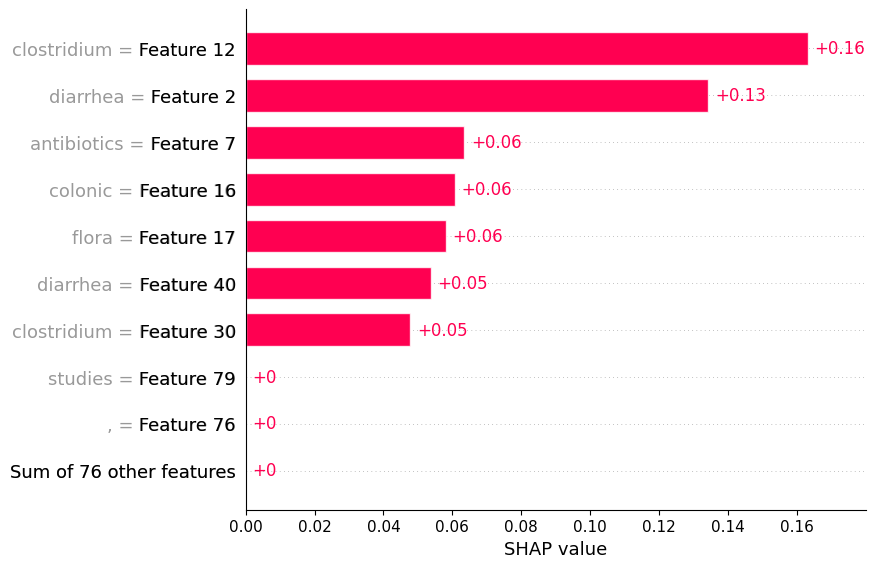

Base Score (Intercept): 0.1157 | Predicted Score: 0.62 | Actual Score: 0.6200


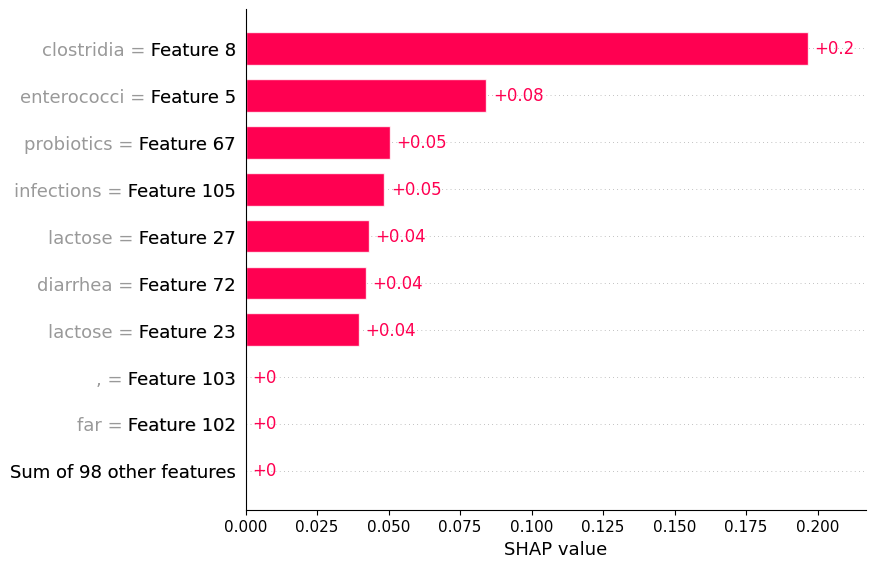

Base Score (Intercept): 0.1172 | Predicted Score: 0.554 | Actual Score: 0.5540


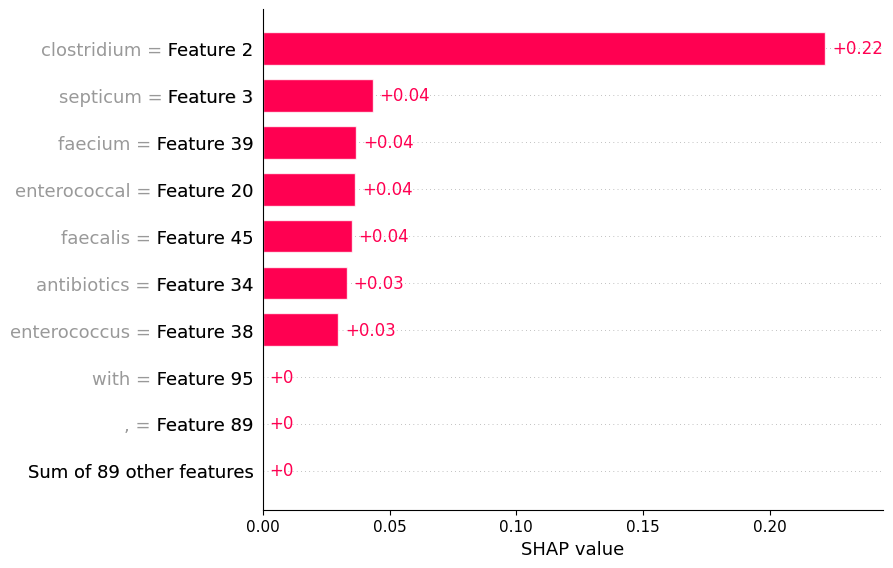

Base Score (Intercept): 0.0537 | Predicted Score: 0.5168 | Actual Score: 0.5168


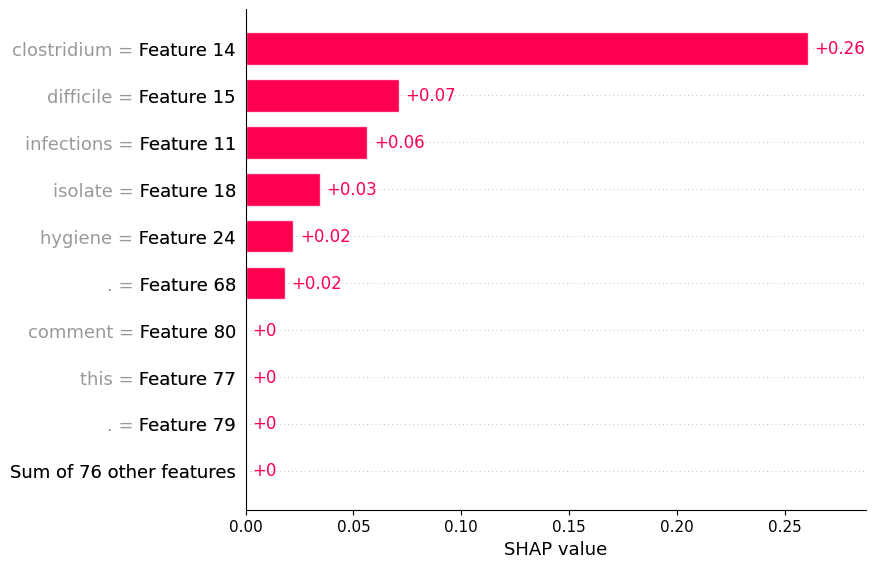


 ------------------------------------

 Query for Hop_2:
"antibiotic resistance Clostridium difficile"



Base Score (Intercept): 0.0392 | Predicted Score: 0.5506 | Actual Score: 0.5506


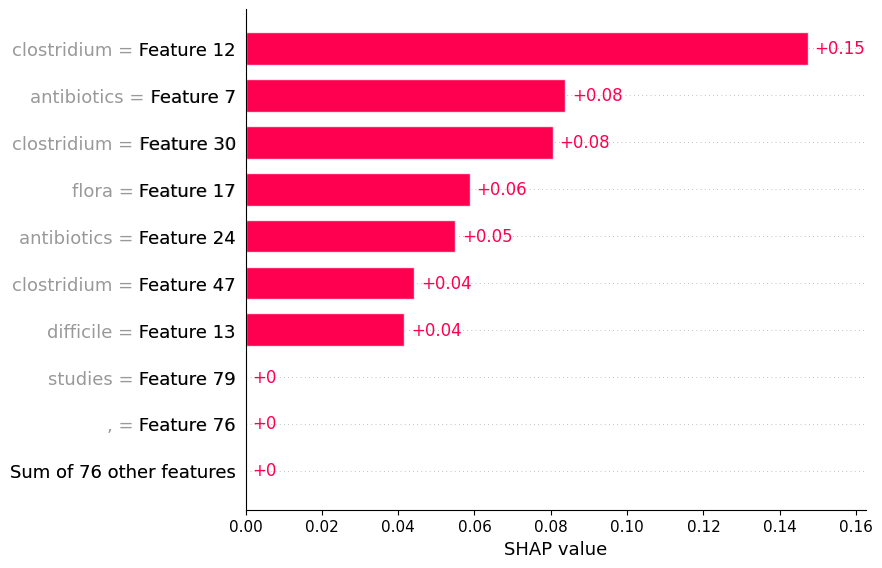

Base Score (Intercept): 0.0255 | Predicted Score: 0.5293 | Actual Score: 0.5293


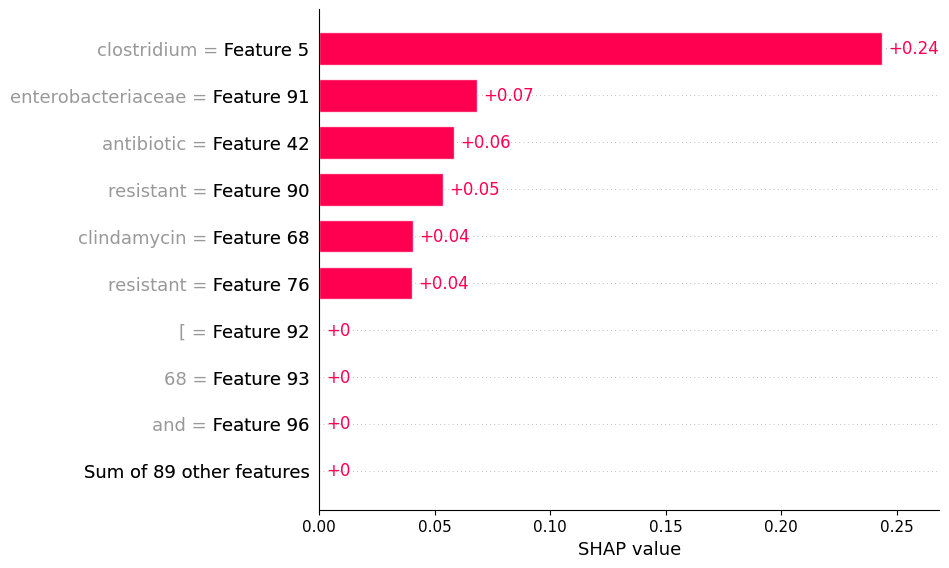

Base Score (Intercept): 0.0451 | Predicted Score: 0.5078 | Actual Score: 0.5078


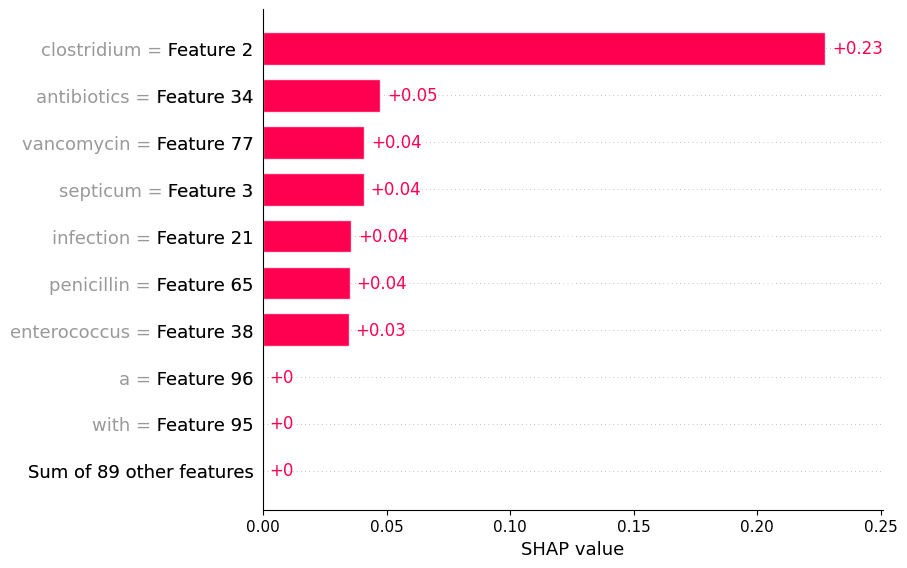

Base Score (Intercept): 0.0051 | Predicted Score: 0.4988 | Actual Score: 0.4988


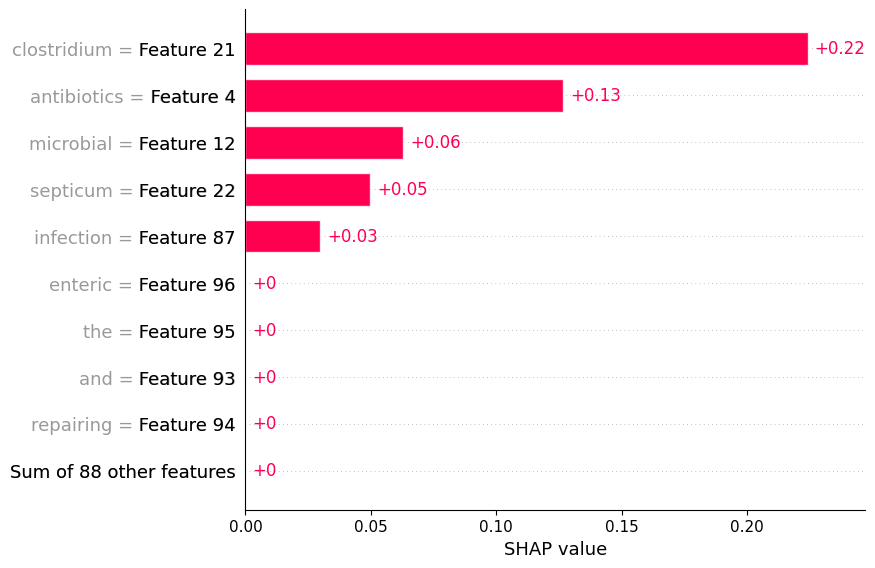

In [ ]:
display_results(shap_explainer, shap_explanations)

Because all Documents in the Database are part of a medical terminology, it's unlikely to find tokens with shap, that negatively impact the cosine similarity. This would more likely be found in a ColBert based RAG-System.

## 3. Lime Explanations

Explaining all documents passed to the context for every question using LimeTextExplainer.

In [ ]:
lime_explainer = LimeExplainer(rag_engine=rag_engine)

In [ ]:
explained_doc_key = "context_documents"
lime_explanations = []

for i, result in enumerate(results):
    print(f"\nExplaining documents for question {i+1}")
    explanation = lime_explainer.explain(result["trace"], explained_doc_key=explained_doc_key)

    lime_explanations.append({"question": result["question"],
                         "final_answer": result["final_answer"],
                         "explanation": explanation})


Explaining documents for question 1
--- LIME Explaining Hop 1 ---
- Explaining Doc 1/4 -
- Explaining Doc 2/4 -
- Explaining Doc 3/4 -
- Explaining Doc 4/4 -
--- LIME Explaining Hop 2 ---
- Explaining Doc 1/4 -
- Explaining Doc 2/4 -
- Explaining Doc 3/4 -
- Explaining Doc 4/4 -


In [ ]:
# save the explanations
save_explanations(lime_explanations, filename="lime_explanations.pkl")

Saved explanations to lime_explanations.pkl


In [ ]:
lime_explanations = load_explanations("lime_explanations.pkl")


 ===== Results for Question: ===== 
 Cause of Clostridium difficile associated diarrhea is

Options:
A: Trauma
B: Dairy products
C: Fried rice
D: Antibiotic use

Query for Hop_1:
Cause of Clostridium difficile associated diarrhea is

Options:
A: Trauma
B: Dairy products
C: Fried rice
D: Antibiotic use



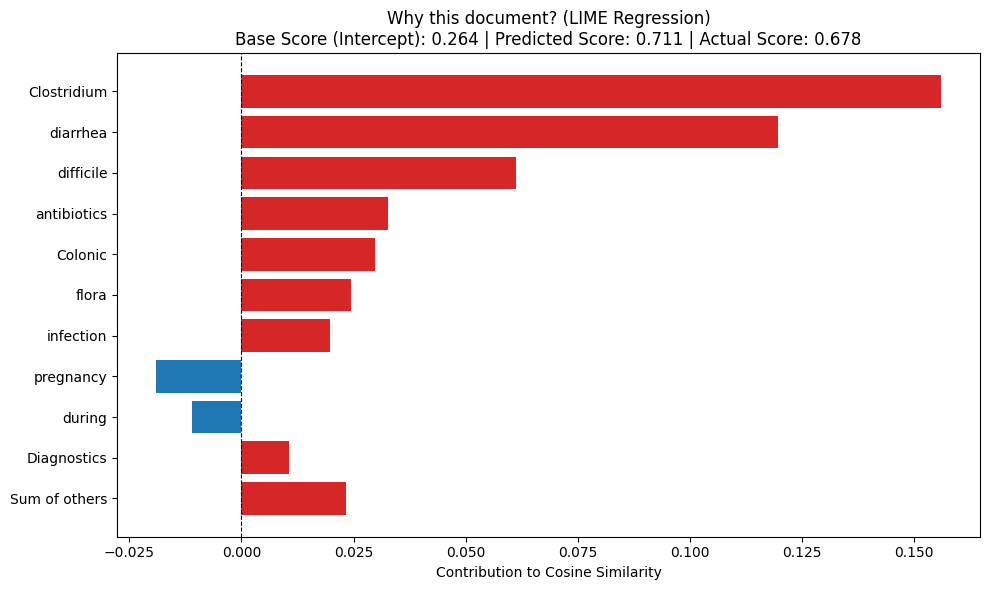

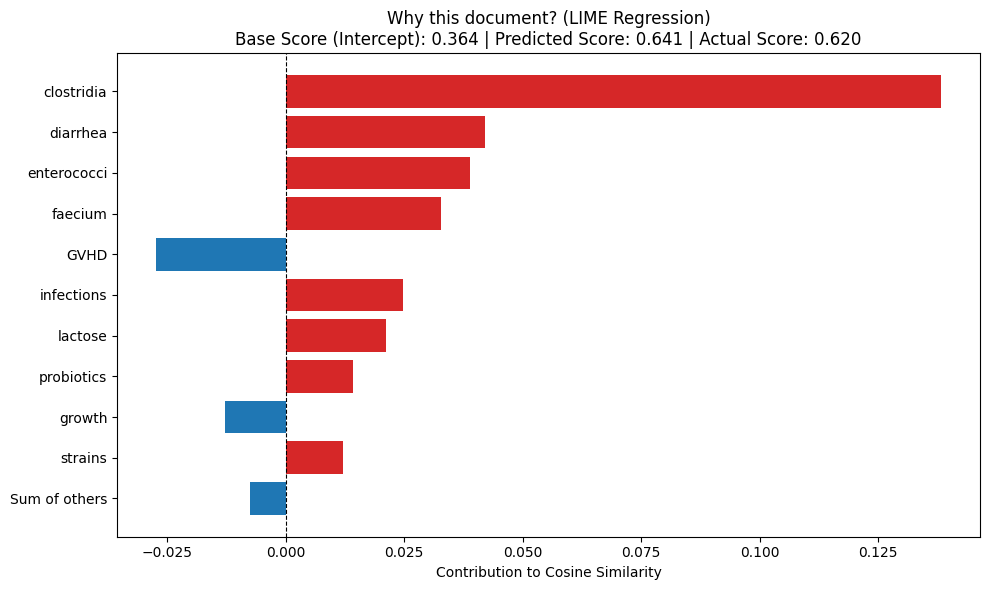

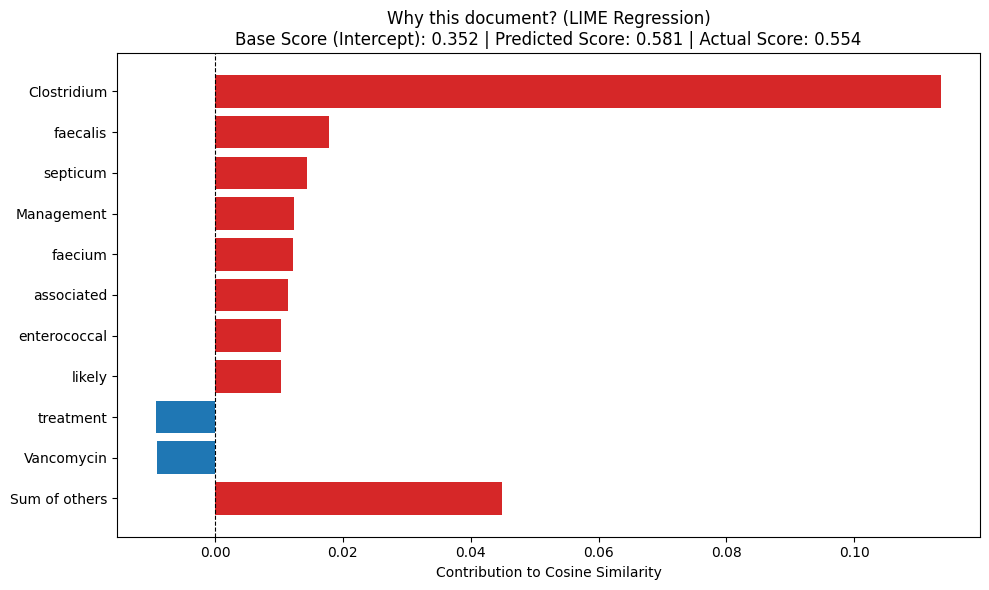

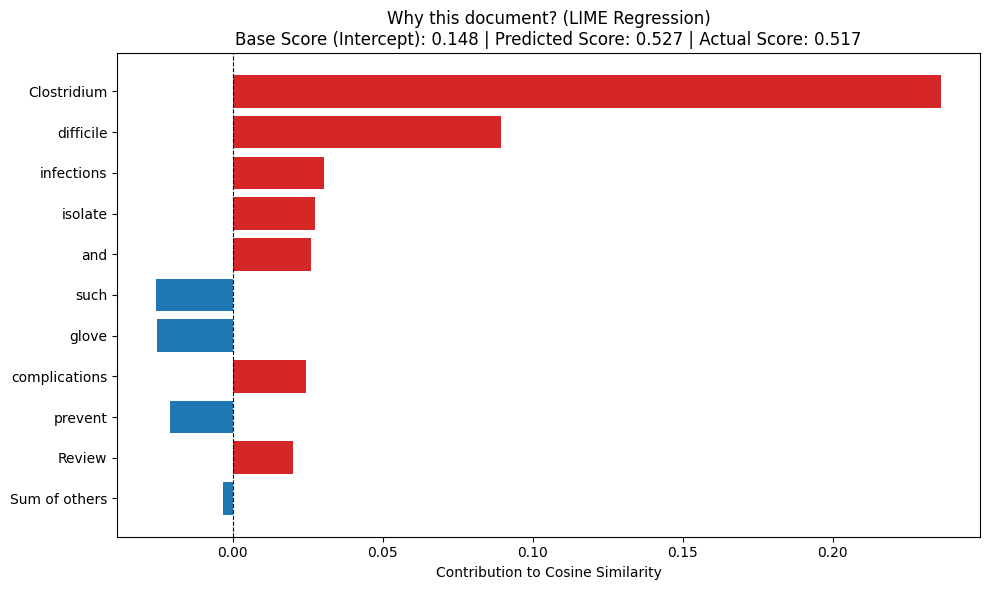


 ------------------------------------

 Query for Hop_2:
"antibiotic resistance Clostridium difficile"



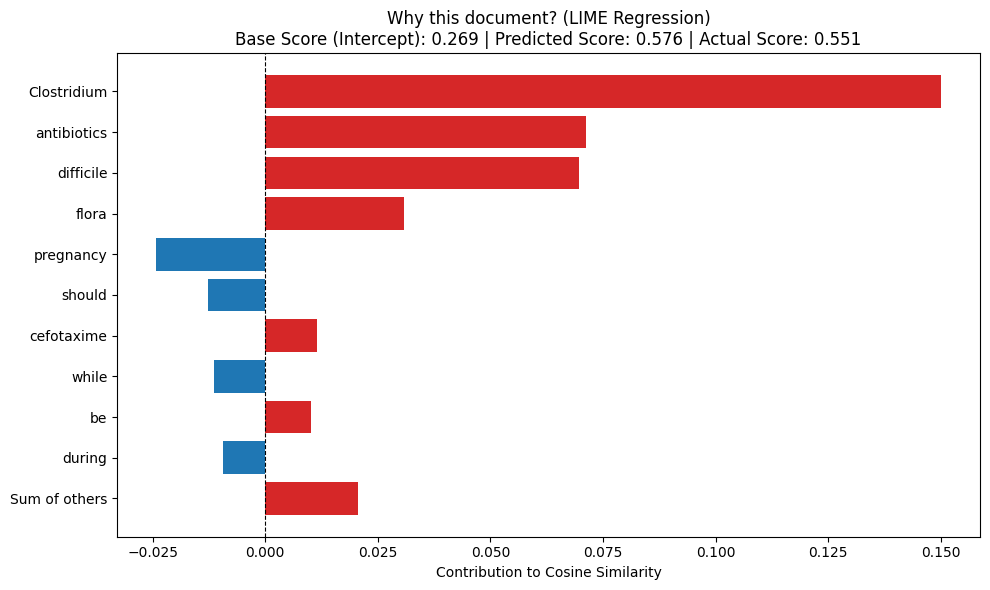

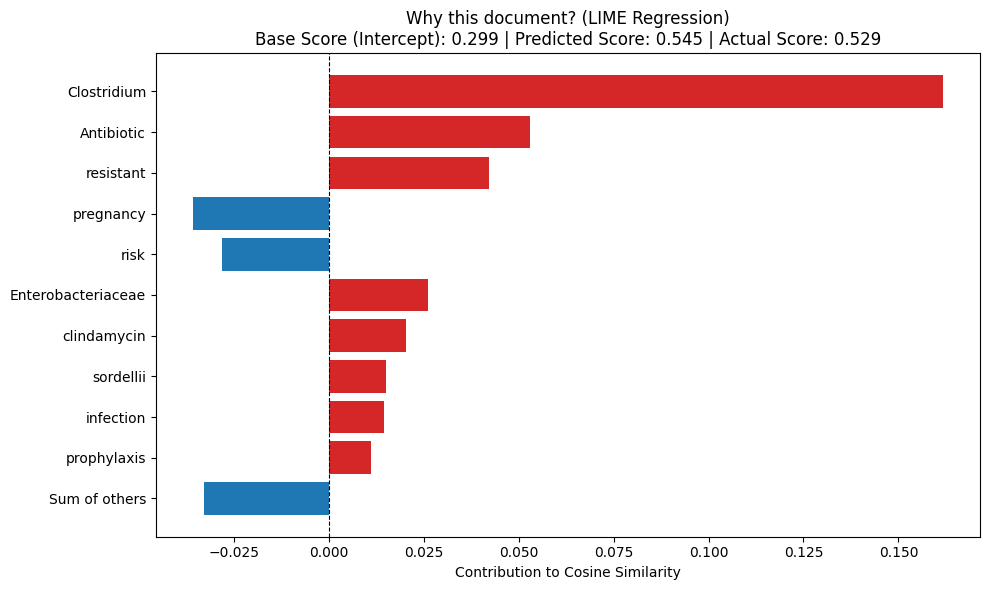

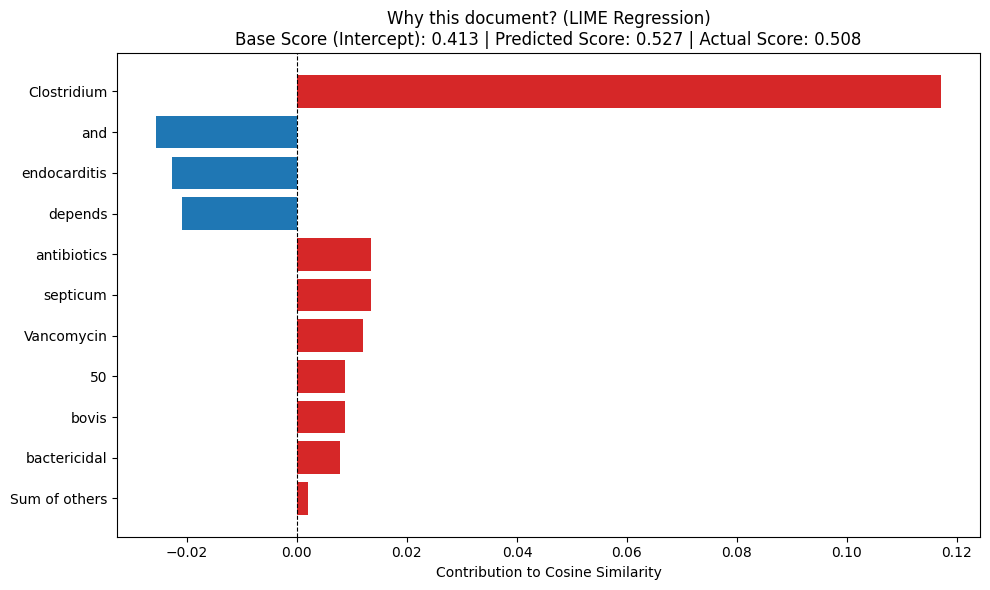

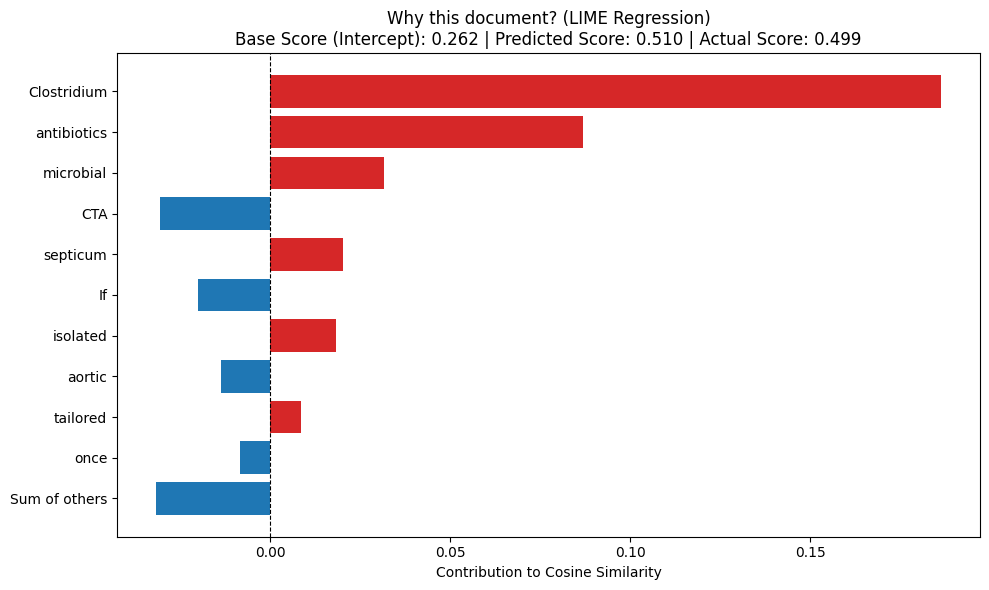

In [ ]:
display_results(lime_explainer, lime_explanations)

## 4. Comparing Lime and Shap

We will now compare, how the Shap and Lime values differ from each other for an observed document.

In [ ]:
lime_explanation = lime_explanations[0]["explanation"]["hop_1"][0]["explanation_tuples"]
shap_explanation = shap_explanations[0]["explanation"]["hop_1"][0]

In [ ]:
import pandas as pd

shap_vals = shap_explanation["shap_values"]
shap_words = shap_explanation["tokens"]

lime_dic = dict(lime_explanation)
lime_dic = {k.lower():v for k,v in lime_dic.items()}

comparison_data = []

for word, s_score in zip(shap_words, shap_vals):
    l_score = lime_dic.get(word, 0.0) 
    
    comparison_data.append({
        "Word": word,
        "SHAP": s_score,
        "LIME": l_score,
        "Difference": abs(s_score - l_score)
    })

df_compare = pd.DataFrame(comparison_data).drop_duplicates()

print("Top Disagreements:")
print(df_compare.sort_values(by="Difference", ascending=False).head(20))

Top Disagreements:
           Word      SHAP      LIME  Difference
47  clostridium  0.000000  0.155974    0.155974
30  clostridium  0.047763  0.155974    0.108211
40     diarrhea  0.053720  0.119705    0.065985
13    difficile  0.000000  0.061316    0.061316
17        flora  0.058196  0.024491    0.033705
24  antibiotics  0.000000  0.032717    0.032717
16      colonic  0.060720  0.029730    0.030990
7   antibiotics  0.063443  0.032717    0.030725
14    infection  0.000000  0.019778    0.019778
75    pregnancy  0.000000 -0.018994    0.018994
2      diarrhea  0.134275  0.119705    0.014570
74       during  0.000000 -0.011084    0.011084
42  diagnostics  0.000000  0.010603    0.010603
63   cefotaxime  0.000000  0.010355    0.010355
5     treatment  0.000000 -0.010297    0.010297
70      careful  0.000000  0.007565    0.007565
12  clostridium  0.163209  0.155974    0.007236
54    depletion  0.000000  0.006587    0.006587
37       severe  0.000000  0.006490    0.006490
33    resulting  0.00

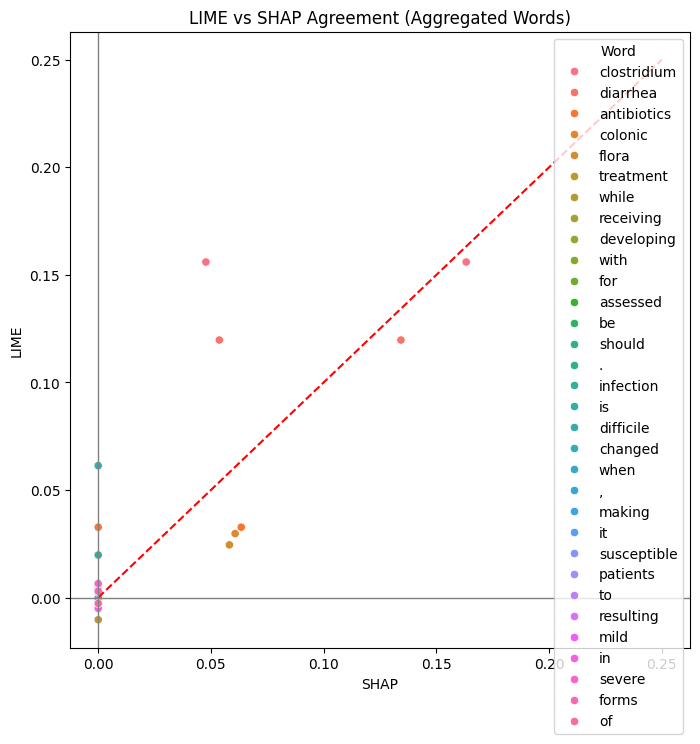

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_compare_plot = df_compare.sort_values(by="SHAP", ascending=False)[:35]

plt.figure(figsize=(8, 8))
sns.scatterplot(data=df_compare_plot, x="SHAP", y="LIME", hue="Word")

# Add a diagonal line (perfect agreement)
plt.plot([0, 0.25], [0, 0.25], color='red', linestyle='--')

plt.title("LIME vs SHAP Agreement (Aggregated Words)")
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.show()

### Evaluating Explanations

Since we are explaining a simple Bert-Based Embedding Model, it would be interesting to observe how often a ranking of the documents was based on a simple token matching with the query and when ...

In [ ]:
lime_explanation = lime_explanations[0]["explanation"]
shap_explanations_question_1 = shap_explanations[0]["explanation"]

In [ ]:
import inflect
from collections import defaultdict

# plural Engine
p = inflect.engine()

match_count_global = 0
amount_shap_values = 0

for hop in shap_explanations_question_1:
    
    for document_explanation in shap_explanations_hop1:

        print(f"\n{'Query Word':<15} | {'Matched Key':<15} | {'SHAP Value':<10} | {'Result'}")
        print("-" * 60)

        shap_vals = document_explanation["shap_values"]
        shap_words = document_explanation["tokens"]
        shap_lookup = defaultdict(float)
        for word, val in zip(shap_words, shap_vals):
            shap_lookup[word.lower().strip()] += val
        query = document_explanation["query"] # the query stays the same

        amount_shap_values += len([val for val in shap_vals if val != 0])

        for word in query.split():
            
            clean_word = word.strip().lower()
            
            # try exact match first
            match_key = None
            if clean_word in shap_lookup:
                match_key = clean_word
            
            # if no exact match, try plural and singular form
            else:
                plural_word = p.plural_noun(clean_word)
                singular_word = p.singular_noun(clean_word)
                
                if plural_word and plural_word in shap_lookup:
                    match_key = plural_word

                elif singular_word and singular_word in shap_lookup:
                    match_kex = singular_word
                    
            if match_key:
                shap_val = shap_lookup[match_key]
                
                if shap_val != 0:
                    print(f"{clean_word:<15} | {match_key:<15} | {shap_val:<10.2f} | Match!")
                    match_count_global += 1
                else:
                    print(f"{clean_word:<15} | {match_key:<15} | {shap_val:<10.2f} | Value too low")
            else:
                print(f"{clean_word:<15} | {'None':<15} | {'-':<10} | Not in Doc")


Query Word      | Matched Key     | SHAP Value | Result
------------------------------------------------------------
cause           | None            | -          | Not in Doc
of              | of              | 0.00       | Value too low
clostridium     | clostridium     | 0.21       | Match!
difficile       | difficile       | 0.00       | Value too low
associated      | None            | -          | Not in Doc
diarrhea        | diarrhea        | 0.19       | Match!
is              | is              | 0.00       | Value too low
options:        | None            | -          | Not in Doc
a:              | None            | -          | Not in Doc
trauma          | None            | -          | Not in Doc
b:              | None            | -          | Not in Doc
dairy           | None            | -          | Not in Doc
products        | None            | -          | Not in Doc
c:              | None            | -          | Not in Doc
fried           | None            | -    

Now we can calculate the matches across all query document pairs to find the ratios.

In [ ]:
print(f"Ratio Token matching: {(match_count_global / amount_shap_values*100):.2f}%")

Ratio Token matching: 29.63%


This does not include observed matches, where verbs and nouns (e.g. **teach** and **teach**er) are matched or similarly words have sub-words contained within eachother (e.g.anti**biotics** and pro**biotics**).